In [289]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    'min_ptu_price_known',
    "max_ptu_price_known",
    "settlement_price_bestguess",
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
    'ptu_id',
    'naive_strategy_action'
]
# already used
target = 'fix_two_sided_ptu'

In [291]:
# Load df and create splits
df = load_df()
splits = get_splits(df, features)

# Split the data in vars
train_data = splits['train']
valid_data = splits['valid']
test_data = splits['test']

In [292]:
# Hyperparameters
ptu_window = 10 # Dit is het PTU aantal dus ptu_id's niet row aantal
batch_size = 15000
input_size =  16 # LET OP PAS AAN VOOR HET AANTAL FEATURES NA PROCESSING
hidden_size = 2
num_layers = 2
output_size = 1
num_epochs = 1
learning_rate = 0.0001
nan_value = 9999

In [293]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, ptu_window, ptu_length=15, nan_value = 9999):
        self.data_in = pd.DataFrame(data['in']).astype(np.float32)
        self.data_out = pd.Series(data['out']).astype(np.float32)
        self.ptu_window = ptu_window
        self.ptu_length = ptu_length

        self.ptu_history = self.ptu_window * self.ptu_length  # Entire window
        self.data_in = self.difference_published() # publish info bool

        self.sequence_indices, self.sequence_lengths = self.create_sequences()
        self.data_in = self.data_in.fillna({'upward_dispatch_published':nan_value, 'downward_dispatch_published':nan_value,
                                           'min_ptu_price_known':nan_value, 'max_ptu_price_known':nan_value, 'settlement_price_bestguess':nan_value,
                                           'forecast_wind':nan_value, 'forecast_solar':nan_value, 'forecast_demand':nan_value}).astype(np.float32)
    
    def difference_published(self):
        conditions = [
            (self.data_in['min_price_published'].notna() & self.data_in['max_price_published'].isna()),  # feature1 has value, feature2 is NaN
            (self.data_in['min_price_published'].isna() & self.data_in['max_price_published'].notna()),  # feature1 is NaN, feature2 has value
            (self.data_in['min_price_published'].isna() & self.data_in['max_price_published'].isna()),   # both feature1 and feature2 are NaN
            (self.data_in['min_price_published'].notna() & self.data_in['max_price_published'].notna())  # both feature1 and feature2 have values
        ]
        values = [0., 1., 2., 3.]
        self.data_in['publish_info'] = np.select(conditions, values)
        self.data_in.drop(columns=['min_price_published', 'max_price_published'], inplace=True)
        return self.data_in



    def create_sequences(self):
        sequence_indices, sequence_lengths = [], []

        row_idx = 0  # Index of the current row
        start_idx = 0  # Index of the furthest row in history

        counter = self.ptu_length

        for _ in range(len(self.data_in)):
            sequence_indices.append((start_idx, row_idx))
            sequence_lengths.append(row_idx - start_idx)  # Add length of sequence

            if row_idx >= self.ptu_history:  # Start using the counter only after padding is passed
                counter -= 1
                if counter == 0:
                    start_idx += self.ptu_length
                    counter = self.ptu_length

            row_idx += 1

        return sequence_indices, sequence_lengths


    def __len__(self):
        return len(self.sequence_indices)

    def __getitem__(self, idx):
        start_idx, row_idx = self.sequence_indices[idx]
        length = self.sequence_lengths[idx]

        # np array sequence and target 
        sequence = self.data_in.iloc[start_idx:row_idx + 1].values  
        target = self.data_out.iloc[row_idx]

        sequence = torch.tensor(sequence, dtype=torch.float32).flip(0)  # draai het om

        # Dit wordt gebruikt voor padding alleen voor de eerdere getallen  waar de history nog incompleet is. 
        if length <= self.ptu_history and start_idx == 0:
            # print(length, start_idx, row_idx)
            sequence = F.pad(sequence, (0, 0, 0, (self.ptu_history - length) + self.ptu_length -1), mode='constant', value=-np.inf)
        
        else:
            # Padding for the dynamic rows in the current ptu
            current_seq_len = self.ptu_length - ((row_idx - start_idx) % self.ptu_length)
            sequence = F.pad(sequence, (0, 0, 0, current_seq_len - 1), mode='constant', value=-np.inf)  # Extra padding
        
        return sequence, torch.tensor(target, dtype=torch.float32), length

In [294]:
class MarkovModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MarkovModel, self).__init__()
        self.lstm = nn.RNN(input_size, hidden_size, num_layers, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Use the last valid output for each sequence
        idx = (lengths - 1).view(-1, 1, 1).expand(output.size(0), 1, output.size(2))
        output = output.gather(1, idx).squeeze(1)
        output = self.fc(output)
        return output


In [295]:
model = MarkovModel(input_size, hidden_size, num_layers, output_size)

tensor_target = torch.tensor(train_data['out']).float()
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(tensor_target)/ tensor_target.sum())*0.452)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.1)


In [296]:
def prepare_data_loader(data, ptu_window, batch_size):
    dataset = TimeSeriesDataset(data, ptu_window)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [297]:
train_loader = prepare_data_loader(train_data, ptu_window, batch_size)
valid_loader = prepare_data_loader(valid_data, ptu_window, batch_size)


In [298]:

def train_rnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, threshold=0.5):
    model.train()

    train_losses = []
    val_losses = []

    
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Training phase
        for batch_idx, (sequences, targets, lengths) in enumerate(train_loader):
            
            print(f"Training batch {batch_idx}, Sequence shape: {sequences.shape}, Lengths: {lengths}")

            sequences = sequences.float()
            targets = targets.float().view(-1, 1)
            lengths += 1
            lengths = lengths.to(torch.int64).cpu()

            # Forward pass
            outputs = model(sequences, lengths)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())

        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for batch_idx, (sequences, targets, lengths) in enumerate(val_loader):

                print(f"Validation batch {batch_idx}, Sequence shape: {sequences.shape}, Lengths: {lengths}")

                sequences = sequences.float()
                targets = targets.float().view(-1, 1)
                lengths += 1
                lengths = lengths.to(torch.int64).cpu()

                outputs = model(sequences, lengths)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                val_losses.append(loss.item())


        train_loss /= len(train_loader)
        val_loss /= len(val_loader)


        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Switch back to training mode
        model.train()
        
    return train_losses, val_losses


train_losses, val_losses = train_rnn(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

Training batch 0, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([  0,   1,   2,  ..., 162, 163, 164])
Training batch 1, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 2, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 3, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 4, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 5, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 6, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 7, Sequence shape: torch.Size([15000, 165, 16]), Lengths: tensor([150, 151, 152,  ..., 162, 163, 164])
Training batch 8, Sequence shape: torch.Size([3840, 165,

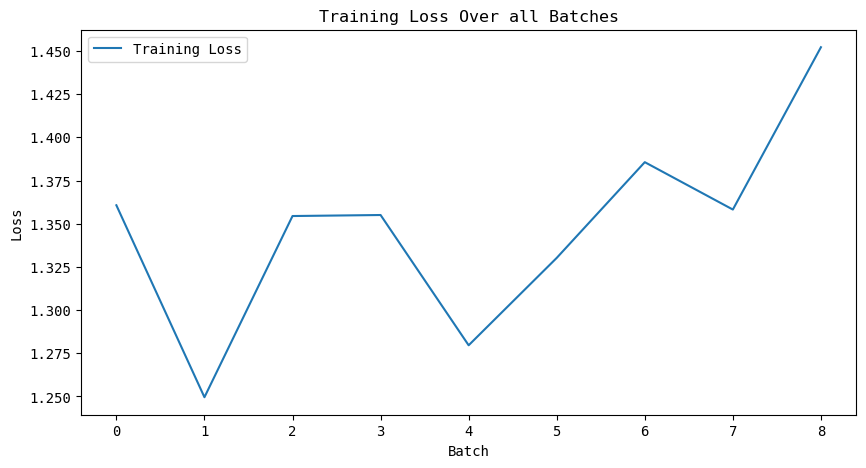

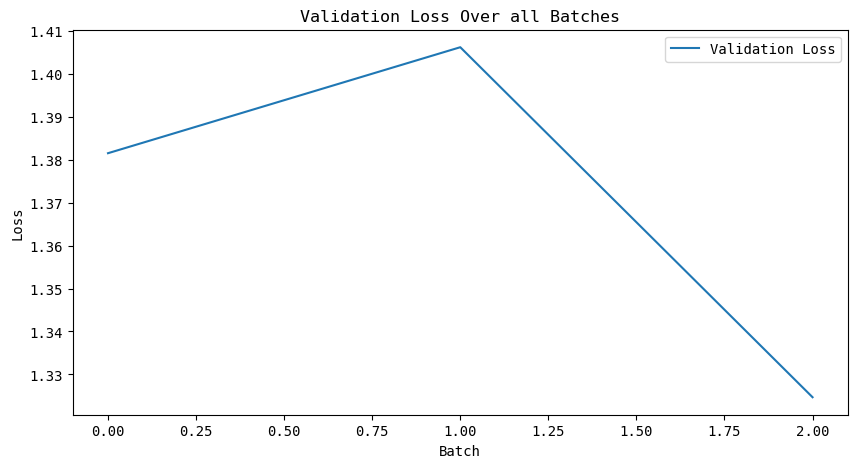

In [299]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over all Batches')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over all Batches')
plt.legend()
plt.show()

In [300]:
save_model(model, f'markovian_model_1', 'rnn')

In [301]:
def test_model(model, data_loader):
    model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets, lengths in data_loader:
            print('hello')
            sequences = sequences.float()
            targets = targets.float()
            lengths += 1

            # Ensure lengths is a 1D CPU int64 tensor
            lengths = lengths.to(torch.int64).cpu()

            # Forward pass
            outputs = model(sequences, lengths)
            all_outputs.append(outputs)
            all_targets.append(targets)
            
    return torch.cat(all_outputs), torch.cat(all_targets)

loaded_model = load_model('markov_adamw3', 'rnn')
outputs, targets = test_model(loaded_model, valid_loader)

hello
hello
hello


In [302]:
# Convert outputs to probabilities
probabilities = torch.sigmoid(outputs)
print(probabilities)
# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate the predictions
accuracy = (predictions == targets.unsqueeze(1)).float().mean()
print(f'Accuracy on valid set: {accuracy:.4f}')


tensor([[0.7056],
        [0.7204],
        [0.7246],
        ...,
        [0.7262],
        [0.7262],
        [0.7262]])
Accuracy on valid set: 0.0497


In [303]:
torch.sum(predictions)


tensor(41760.)

/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

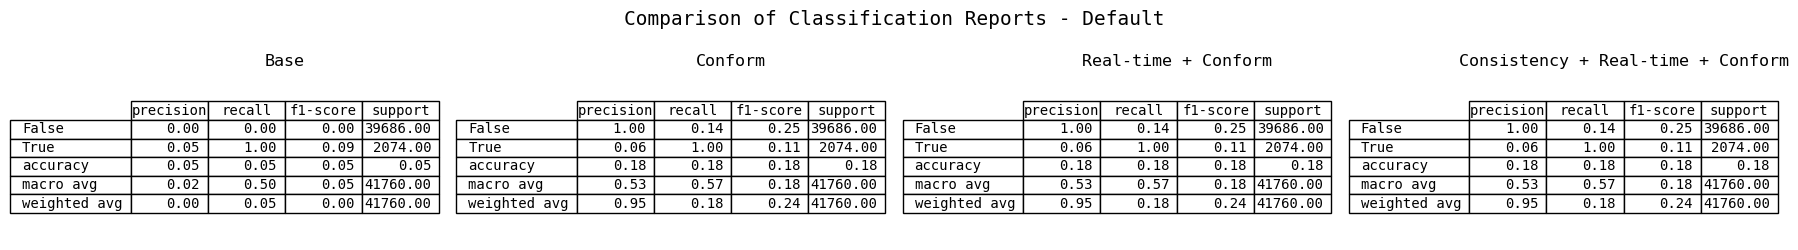

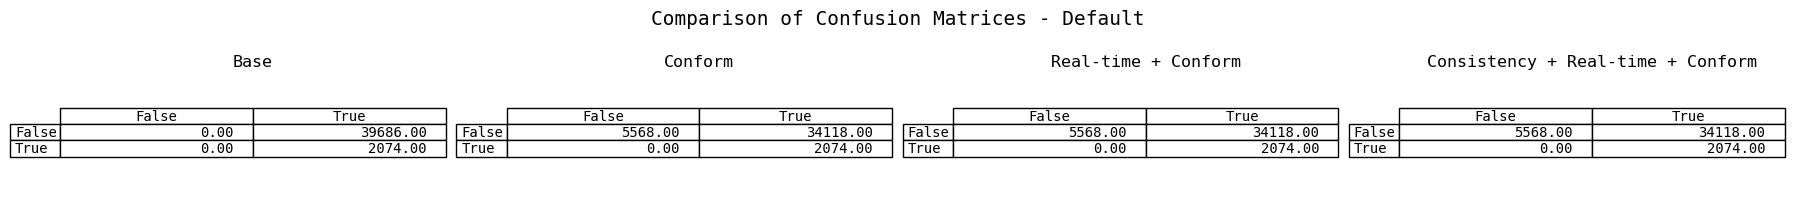

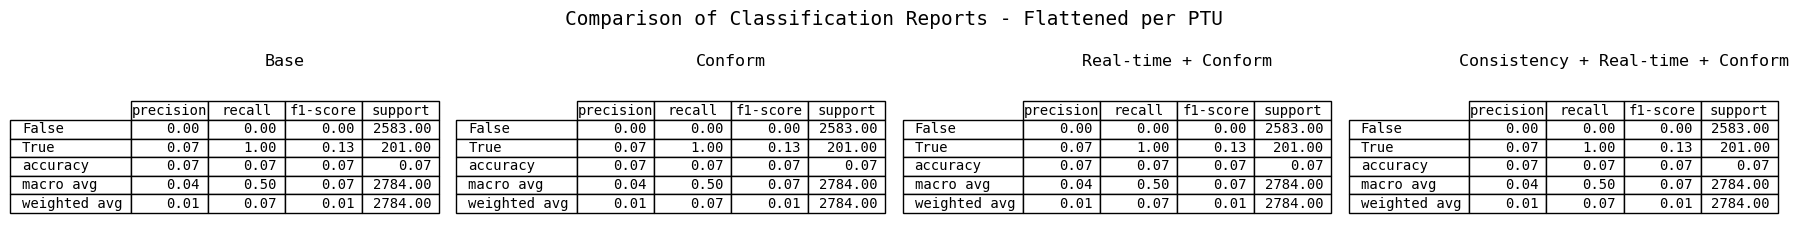

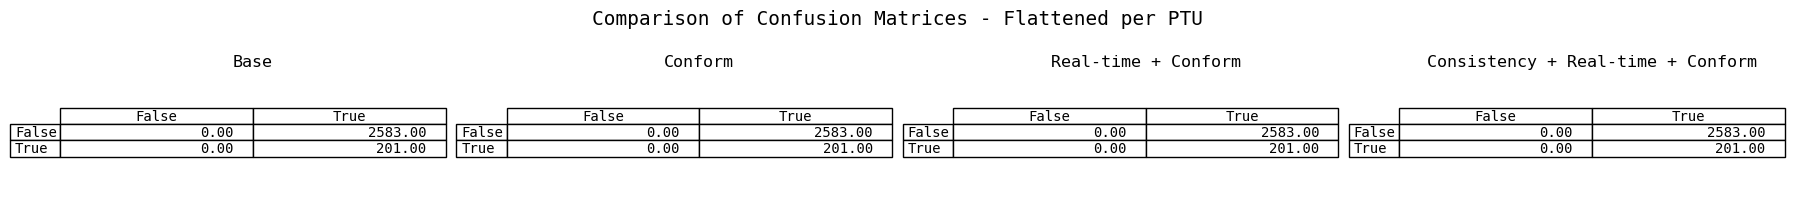

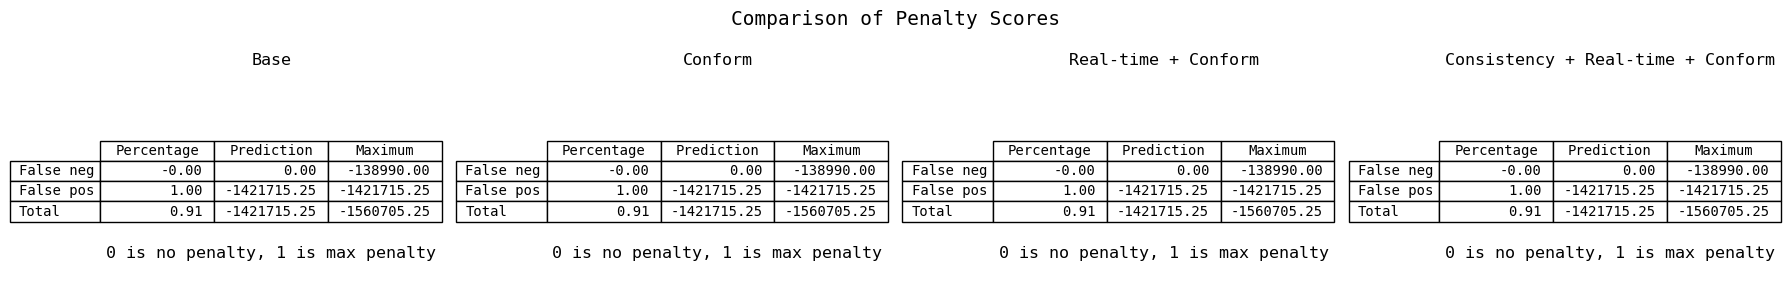

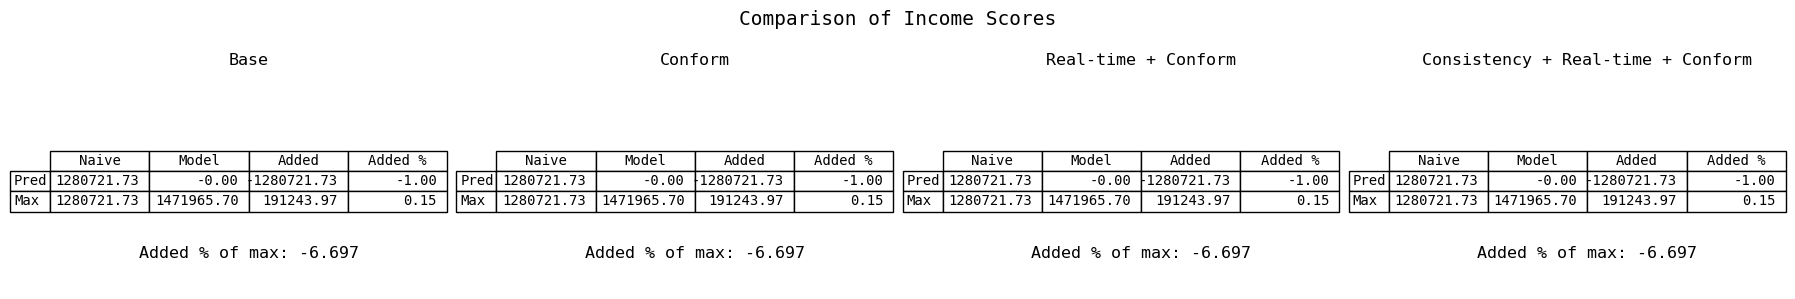

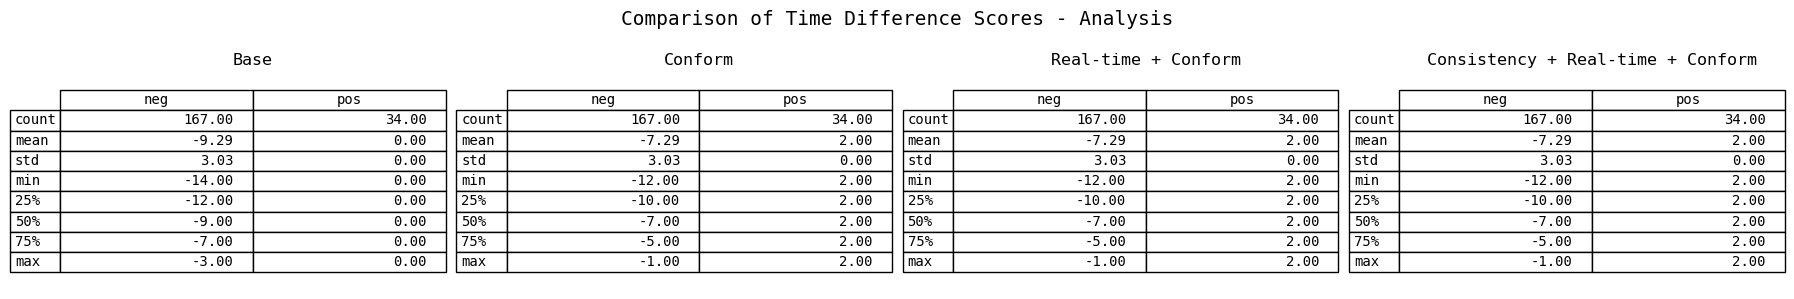

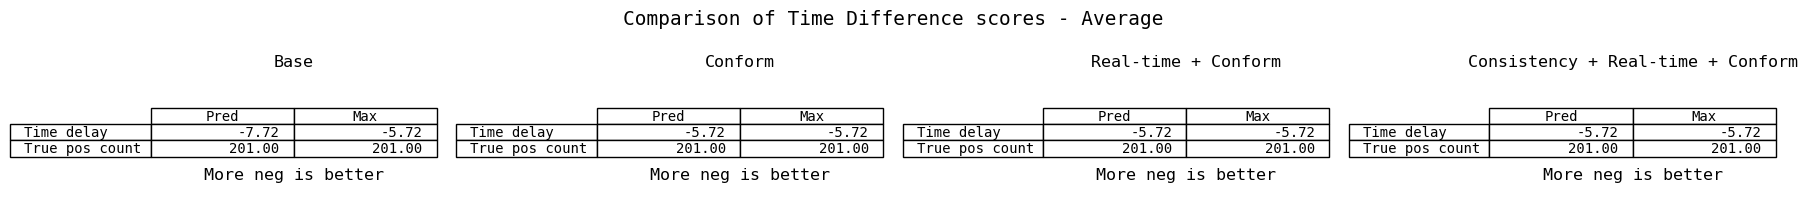

In [304]:
df_pair = valid_data['df']

p1 = recast_pred(predictions.flatten())
show_metrics_adjusted(df_pair, p1)


hello
hello
hello
hello
hello
hello
hello
hello
hello
tensor([[0.6051],
        [0.5821],
        [0.5734],
        ...,
        [0.7261],
        [0.7261],
        [0.7261]])
Accuracy on valid set: 0.0447


/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

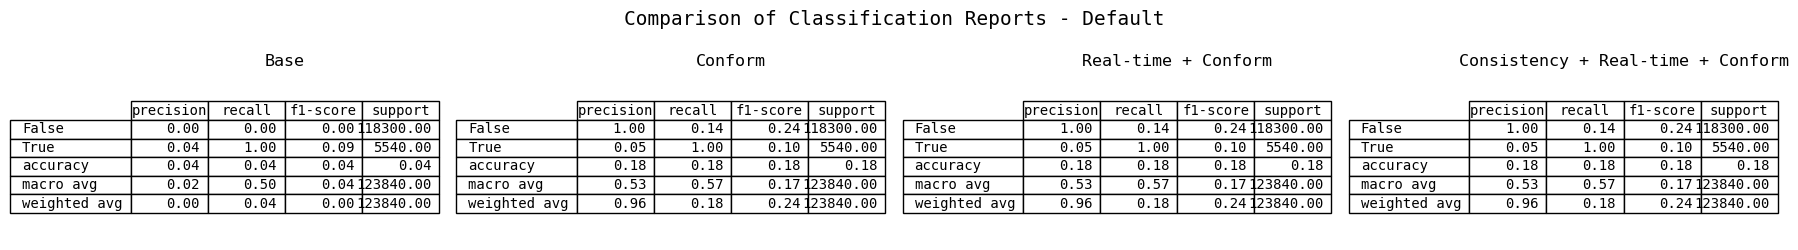

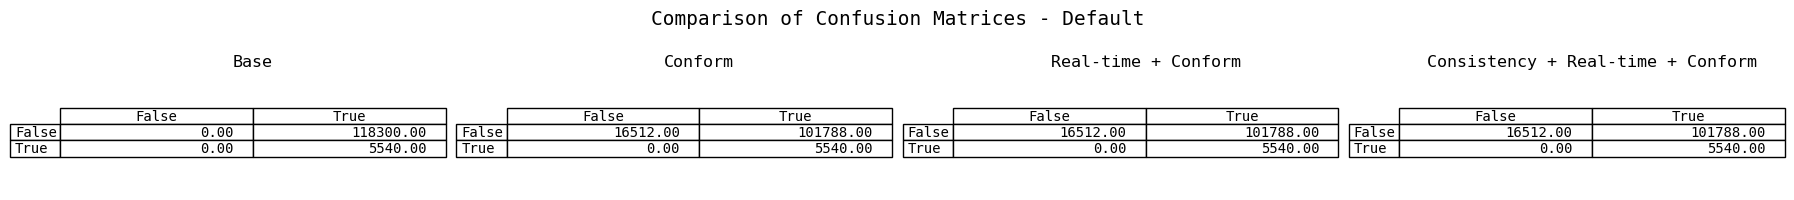

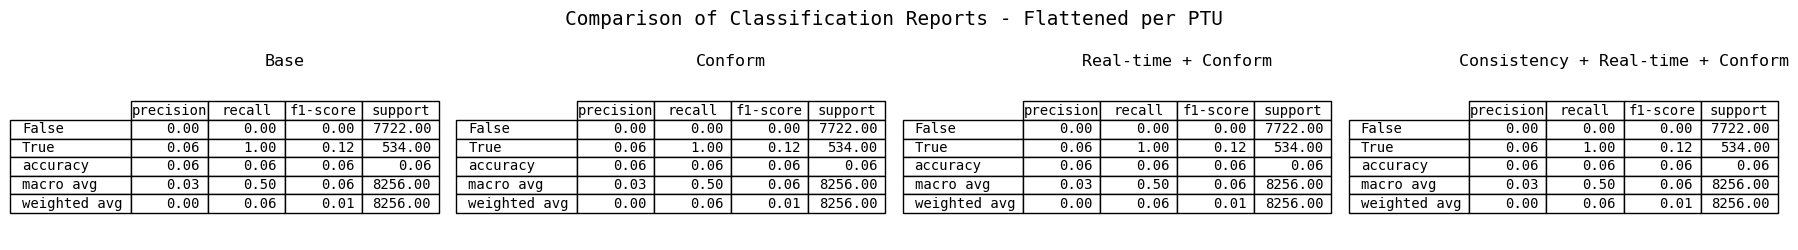

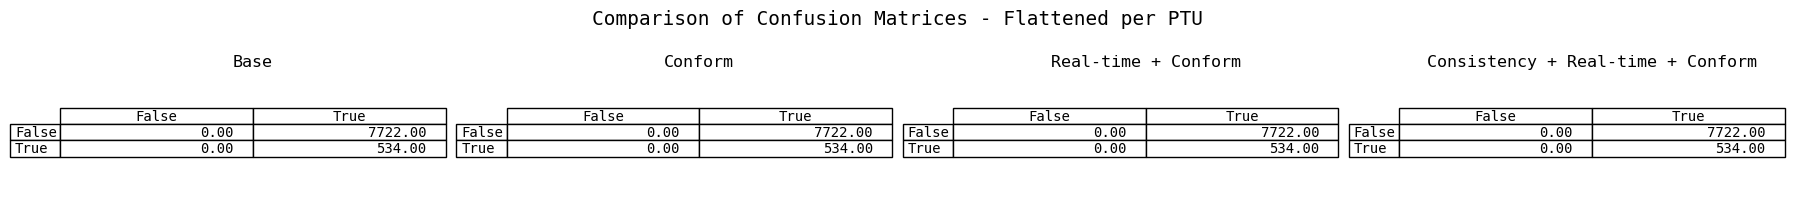

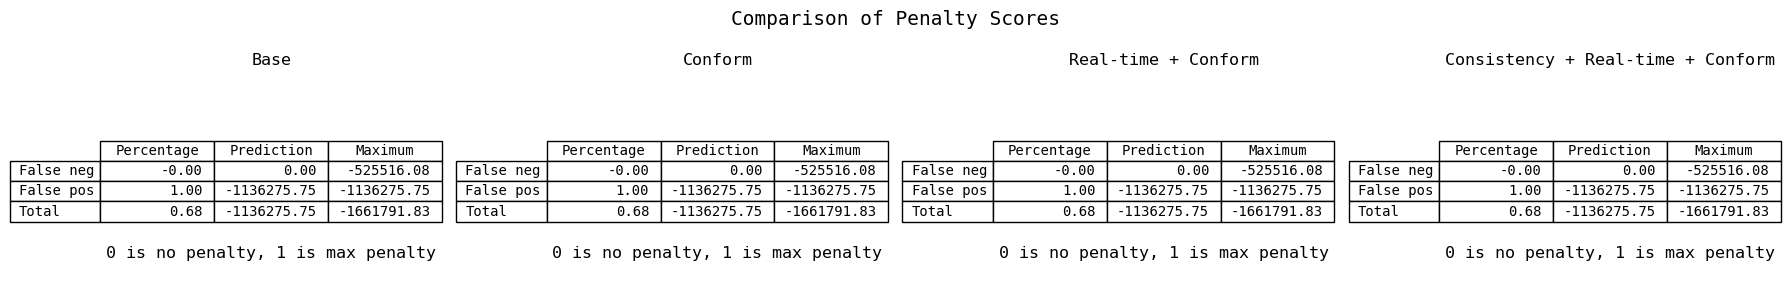

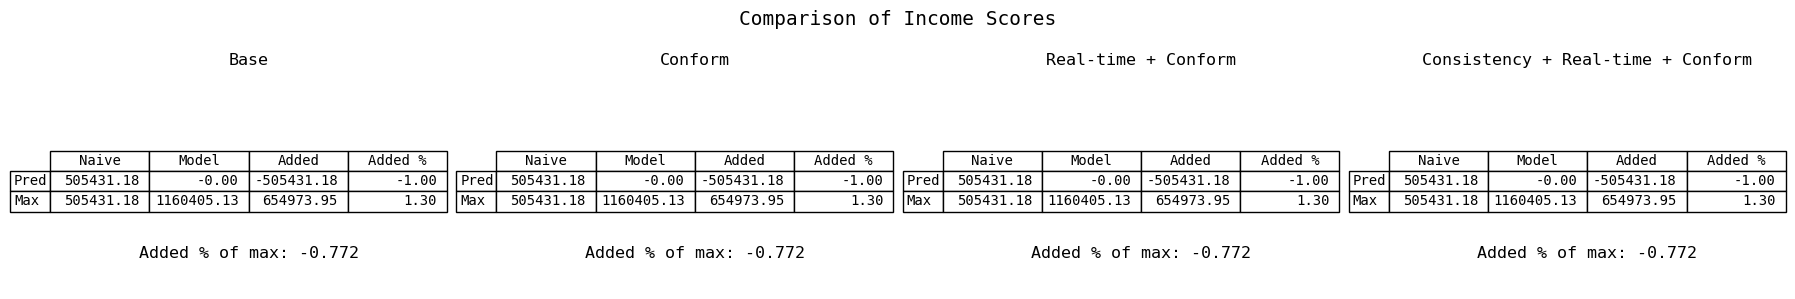

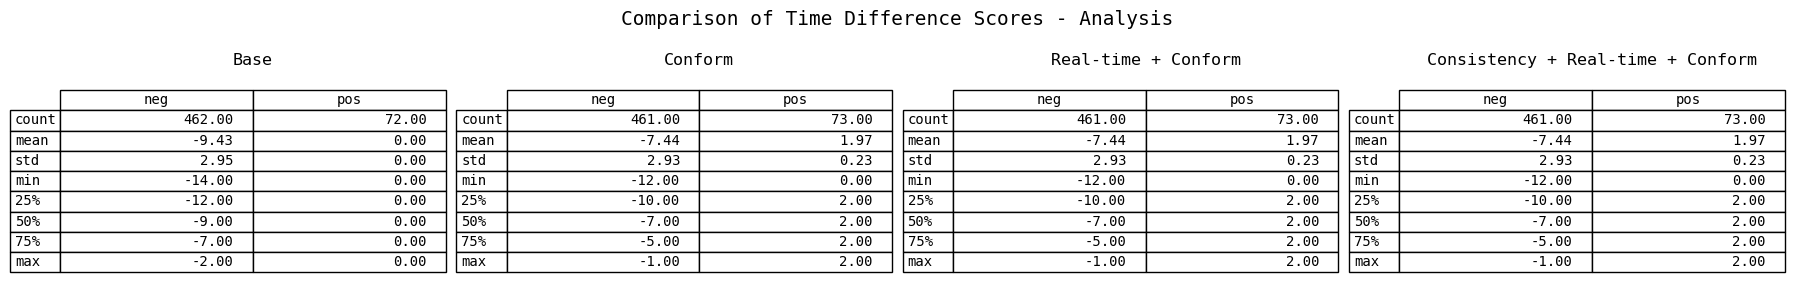

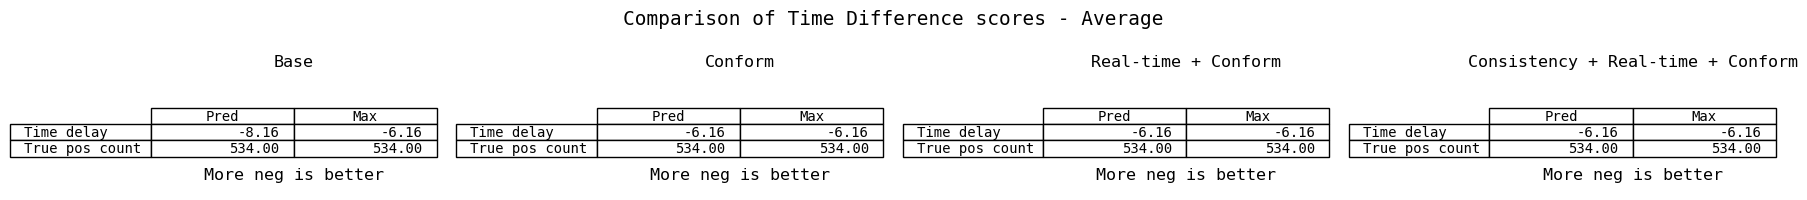

In [305]:
outputs, targets = test_model(loaded_model, train_loader)
df_pair_train = train_data['df']

probabilities = torch.sigmoid(outputs)
print(probabilities)
# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate the predictions
accuracy = (predictions == targets.unsqueeze(1)).float().mean()
print(f'Accuracy on valid set: {accuracy:.4f}')


p1 = recast_pred(predictions.flatten())
show_metrics_adjusted(df_pair_train, p1)

hello
hello
hello
hello
tensor([[0.7056],
        [0.7204],
        [0.7246],
        ...,
        [0.7262],
        [0.7262],
        [0.7262]])
Accuracy on valid set: 0.0187


/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nordin/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

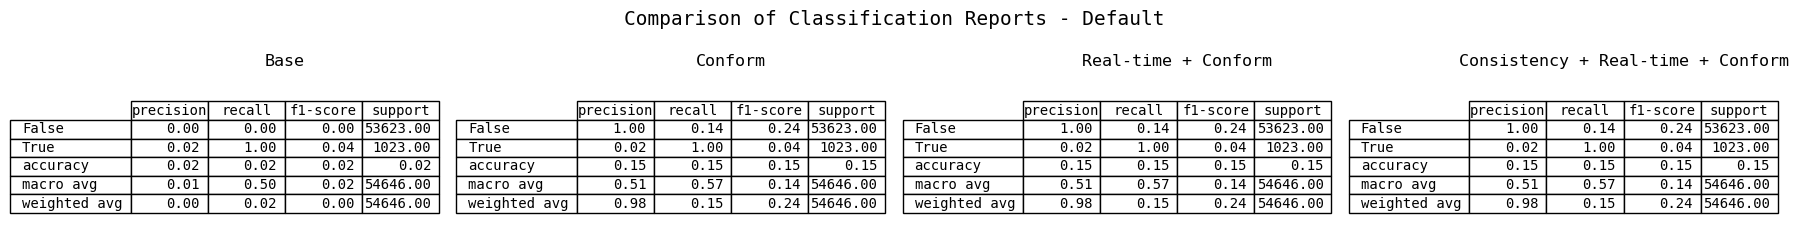

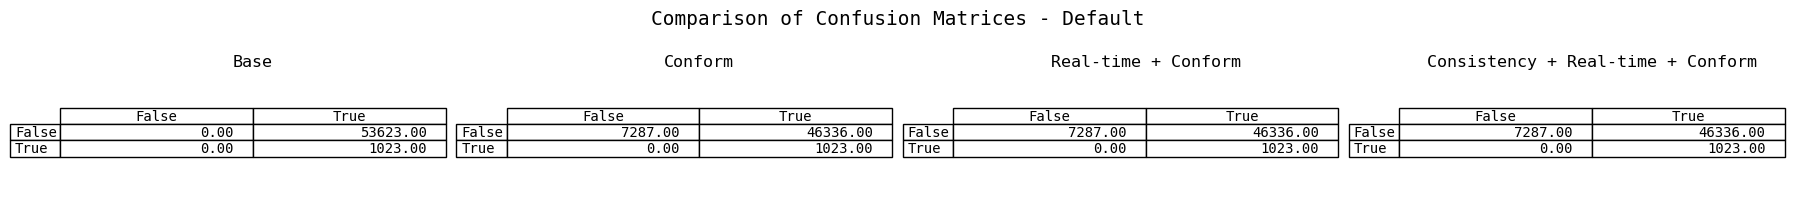

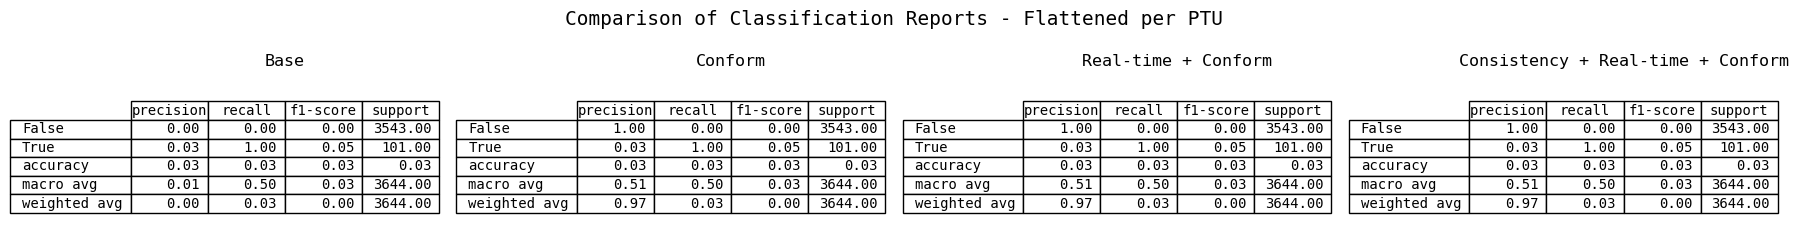

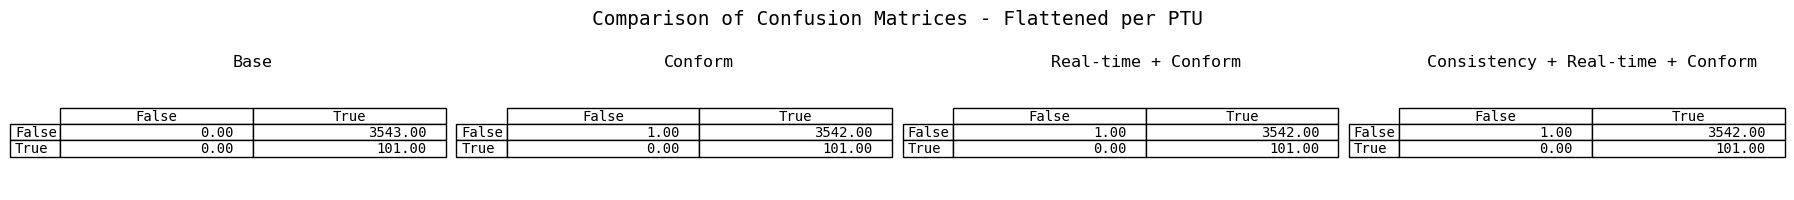

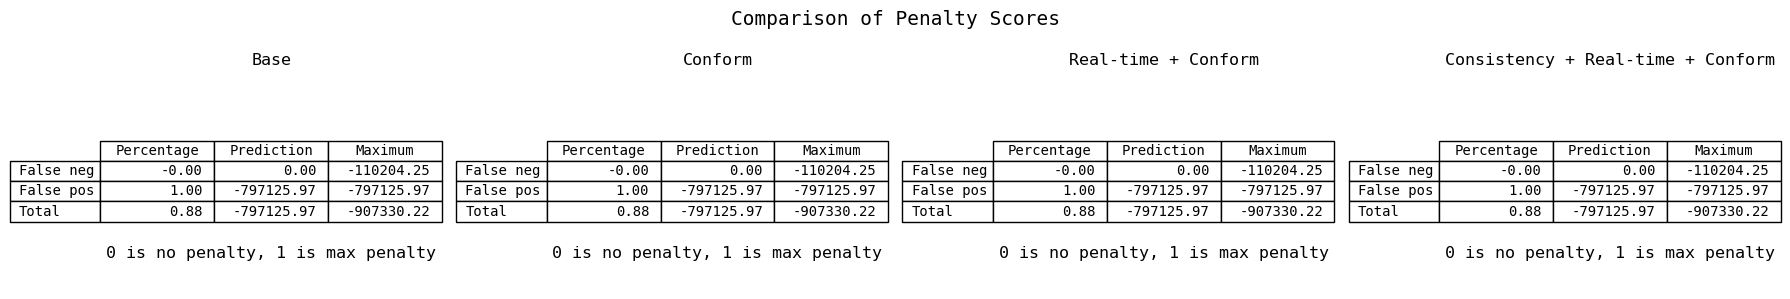

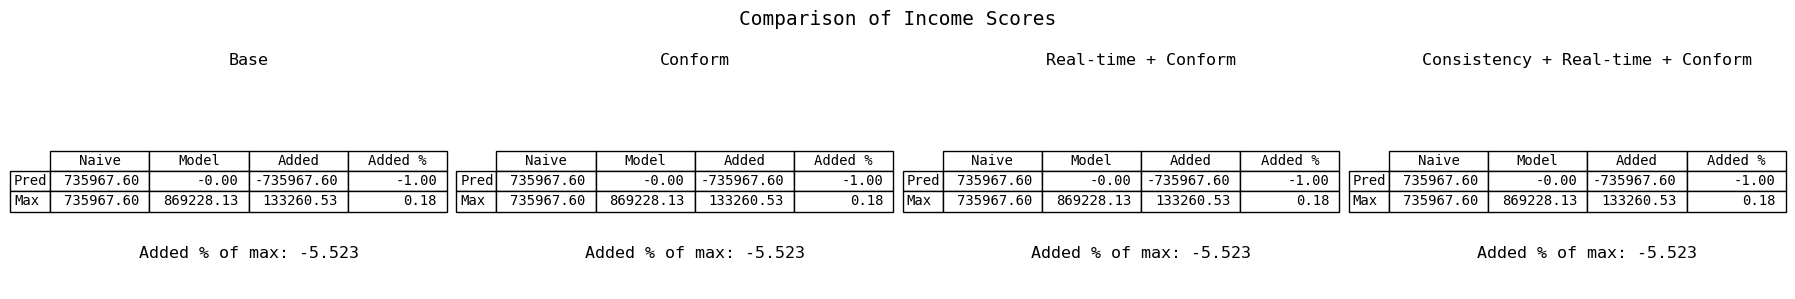

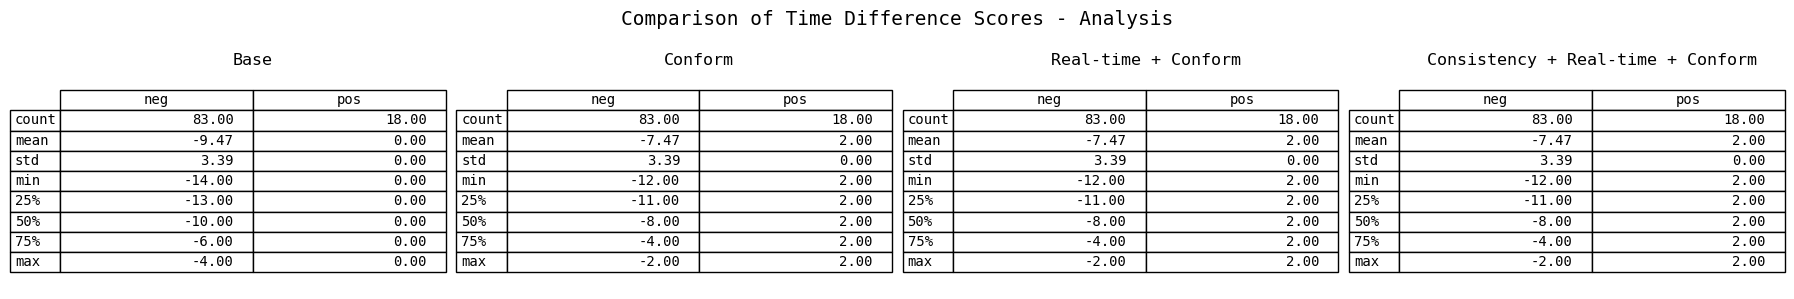

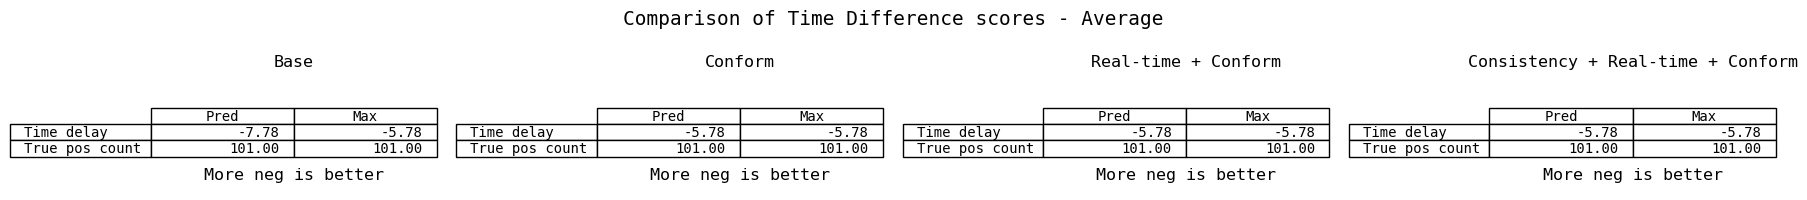

In [306]:
test_loader = prepare_data_loader(test_data, ptu_window, batch_size)

outputs, targets = test_model(loaded_model, test_loader)
df_pair_train = test_data['df']

probabilities = torch.sigmoid(outputs)
print(probabilities)
# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate the predictions
accuracy = (predictions == targets.unsqueeze(1)).float().mean()
print(f'Accuracy on valid set: {accuracy:.4f}')


p1 = recast_pred(predictions.flatten())
show_metrics_adjusted(df_pair_train, p1)

In [307]:
# model = RNNModel(input_size, hidden_size, num_layers, output_size)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [308]:
# for batch_idx, (sequences, targets) in enumerate(train_loader):
#     print("Batch:", batch_idx)
#     print("Sequence shape:", sequences.shape)  # Print the shape of the input sequences
#     print("Targets shape:", targets.shape)  # Print the shape of the targets


In [309]:
# # Training loop (placeholder, implement training logic)
# for epoch in range(1):
#     for sequences, targets in train_loader:
#         lengths = [min(len(seq), sequence_length) for seq in sequences]
#         optimizer.zero_grad()
#         outputs = model(sequences, lengths)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
